In [ ]:
!pip install mlflow
!pip install pyngrok

In [ ]:
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input

import mlflow
import mlflow.keras
import subprocess
from pyngrok import ngrok, conf
import getpass

import warnings
warnings.filterwarnings("ignore")



In [ ]:
os.system("pkill mlflow")
os.system("pkill ngrok")

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment('EgyptLandmarks')

get_ipython().system_raw("nohup mlflow ui --backend-store-uri sqlite:///mlflow.db --host 0.0.0.0 --port 5000 > mlflow.log 2>&1 &")

time.sleep(5)

if not conf.get_default().auth_token:
    conf.get_default().auth_token = getpass.getpass()

port = 5000
public_url = ngrok.connect(port, "http", bind_tls=True, host_header="rewrite").public_url

print(public_url)

2025/11/28 18:25:35 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/11/28 18:25:35 INFO mlflow.store.db.utils: Updating database tables
2025-11-28 18:25:35 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-28 18:25:35 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
2025-11-28 18:25:35 INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
2025-11-28 18:25:35 INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


··········
https://nonincreasing-leana-untrimmed.ngrok-free.dev


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
BASE_DRIVE_PATH = '/content/drive/MyDrive/Egypt/Egypt Landmarks.v5i.multiclass'
TRAIN_DIR = os.path.join(BASE_DRIVE_PATH, 'train')
VALID_DIR = os.path.join(BASE_DRIVE_PATH, 'valid')
TEST_DIR = os.path.join(BASE_DRIVE_PATH, 'test')
CLASSES_CSV_PATH = os.path.join(TRAIN_DIR, '_classes.csv')

df_train_raw = pd.read_csv(CLASSES_CSV_PATH)
label_cols = [col for col in df_train_raw.columns if col != 'filename']

def get_single_label(row):
    active_labels = row[label_cols][row[label_cols] == 1].index.tolist()
    return active_labels[0] if active_labels else 'No_Label'

df_train = df_train_raw.copy()
df_train['filepath'] = df_train['filename'].apply(lambda x: os.path.join(TRAIN_DIR, x))
df_train['label'] = df_train.apply(get_single_label, axis=1)
df_train = df_train[['filepath', 'label']]

VALID_CSV_PATH = os.path.join(VALID_DIR, '_classes.csv')
df_valid_raw = pd.read_csv(VALID_CSV_PATH)

df_valid = df_valid_raw.copy()
df_valid['filepath'] = df_valid['filename'].apply(lambda x: os.path.join(VALID_DIR, x))
df_valid['label'] = df_valid.apply(get_single_label, axis=1)
df_valid = df_valid[['filepath', 'label']]

TEST_CSV_PATH = os.path.join(TEST_DIR, '_classes.csv')
df_test_raw = pd.read_csv(TEST_CSV_PATH)

df_test = df_test_raw.copy()
df_test['filepath'] = df_test['filename'].apply(lambda x: os.path.join(TEST_DIR, x))
df_test['label'] = df_test.apply(get_single_label, axis=1)
df_test = df_test[['filepath', 'label']]

In [ ]:
df = pd.concat([df_train, df_valid, df_test], axis=0)

In [ ]:
df

,filepath,label
0,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Hatshepsut
1,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Temple_of_Kom_Ombo
2,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Temple_of_Kom_Ombo
3,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Khafre-Pyramid
4,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Ramessum
...,...,...
322,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Khafre-Pyramid
323,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Hatshepsut-face
324,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Temple_of_Isis_in_Philae
325,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,Khafre-Pyramid


In [ ]:
df.shape

(7845, 2)

In [ ]:
df.describe().T

,count,unique,top,freq
filepath,7845,7845,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,1
label,7845,23,Khafre-Pyramid,1067


In [ ]:
df['label'].unique()

array([' Hatshepsut', ' Temple_of_Kom_Ombo', ' Khafre-Pyramid',
       ' Ramessum', ' Bent-pyramid-for-senefru',
       ' Temple_of_Isis_in_Philae', ' Colossal-Statue-of-Ramesses-II',
       ' menkaure-pyramid', ' Hatshepsut-face', ' bust-of-ramesses-ii',
       ' Statue-of-King-Zoser', ' Mask-of-Tutankhamun', ' sphinx',
       ' Colossoi-of-Memnon', ' amenhotep-iii-and-tiye',
       ' The-Great-Temple-of-Ramesses-II',
       ' Statue-of-Tutankhamun-with-Ankhesenamun',
       ' Goddess-Isis-with-her-child', ' Akhenaten',
       ' Ramses-II-Red-Granite-Statue', ' Pyramid_of_Djoser',
       ' Nefertiti', 'No_Label'], dtype=object)

In [ ]:
df = df[df['label'] != 'No_Label']

In [ ]:
df.describe().T

,count,unique,top,freq
filepath,7842,7842,/content/drive/MyDrive/Egypt/Egypt Landmarks.v...,1
label,7842,22,Khafre-Pyramid,1067


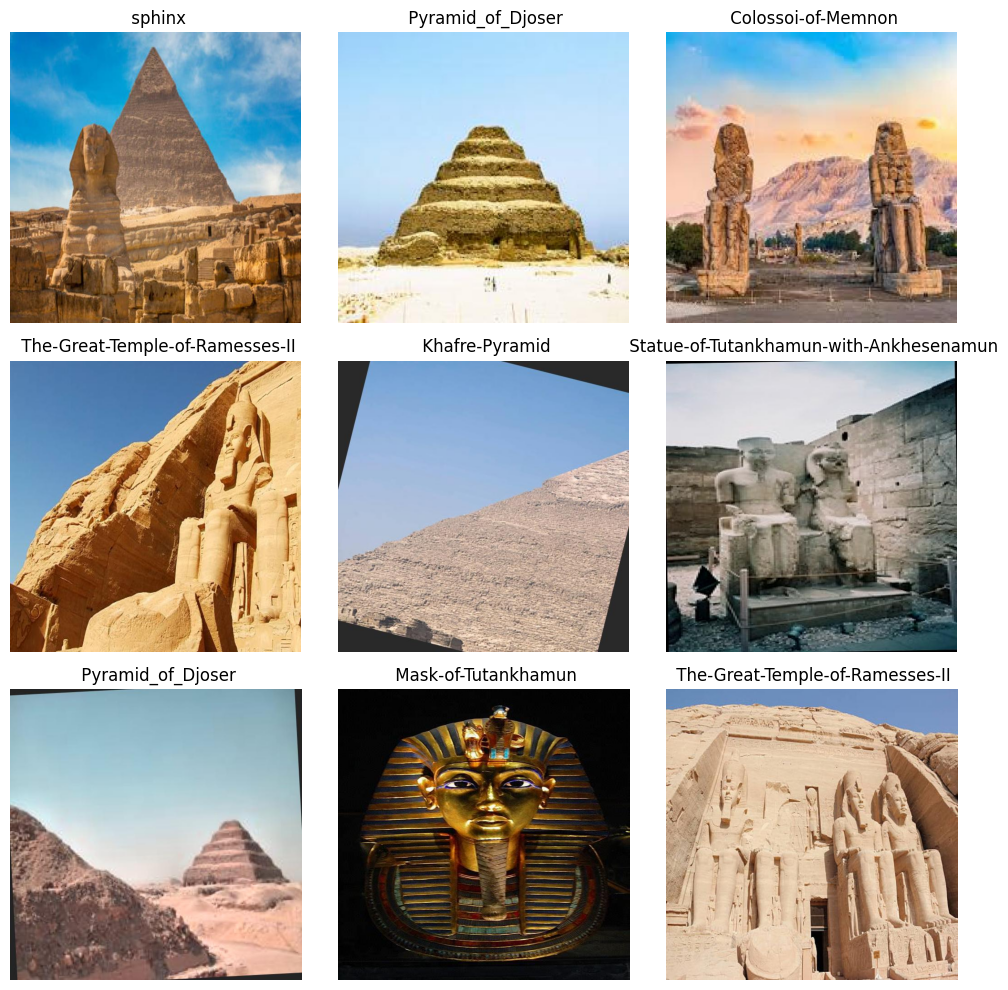

In [ ]:
def show_samples(df, n=9):
    sample_df = df.sample(n)

    plt.figure(figsize=(10, 10))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img = Image.open(row['filepath'])

        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(row['label'])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

show_samples(df, n=9)

In [ ]:
df['label'].value_counts()

,count
label,
Khafre-Pyramid,1067
Bent-pyramid-for-senefru,745
Hatshepsut,692
sphinx,685
Colossoi-of-Memnon,523
The-Great-Temple-of-Ramesses-II,479
Mask-of-Tutankhamun,441
Ramessum,388
menkaure-pyramid,282


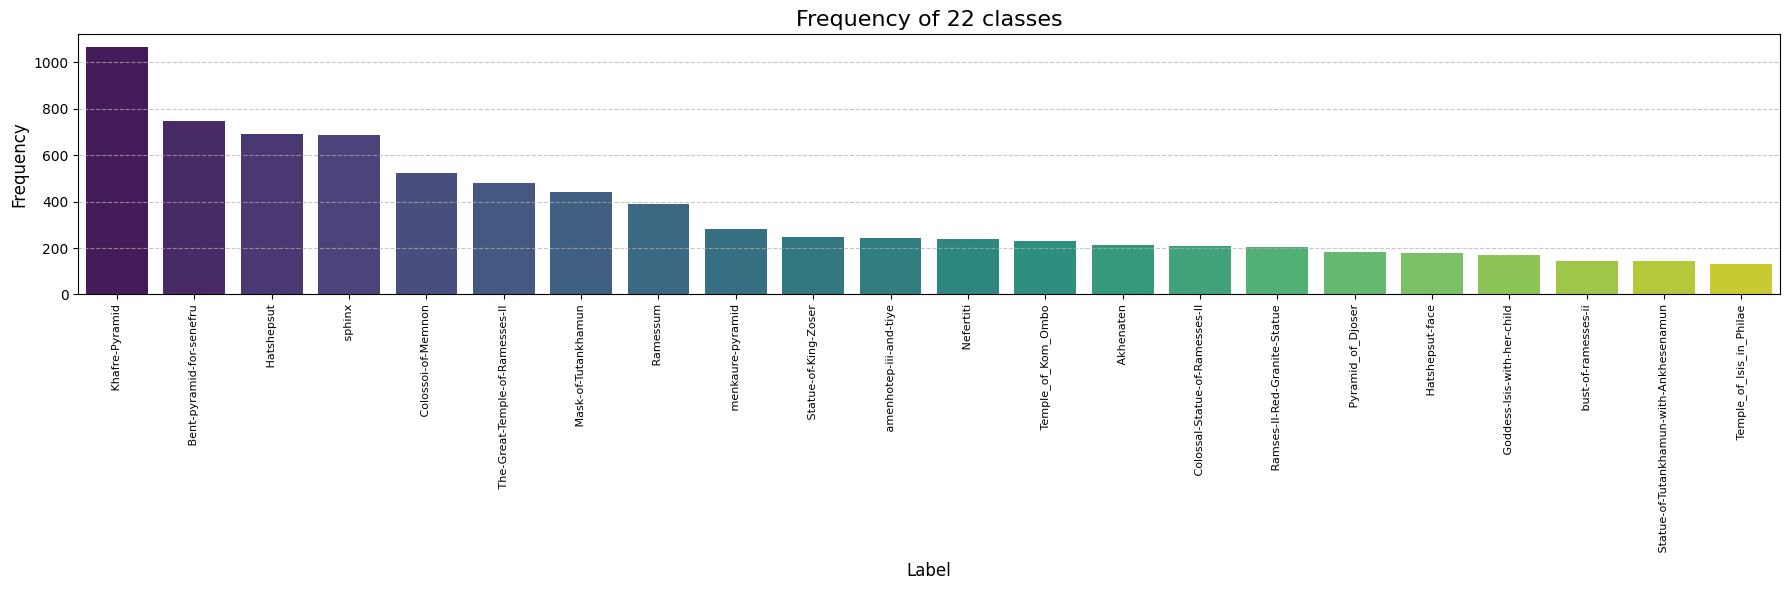

In [ ]:
label_counts = df['label'].value_counts()
num_classes = len(label_counts)

plt.figure(figsize=(18, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title(f'Frequency of {num_classes} classes', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Impalanced Data

In [ ]:
train_df, test_valid_df = train_test_split(df, test_size=0.2, shuffle = True,
                                           random_state=42, stratify=df['label'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, shuffle = True,
                                           random_state=42, stratify=test_valid_df['label'])

In [ ]:
mlflow.tensorflow.autolog()

In [ ]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range = 5,
    zoom_range = 0.02,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    horizontal_flip=True,
    brightness_range=[0.95, 1.01],
    fill_mode = 'nearest',
)

train_gen = gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size = (224, 224),
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = True,
    batch_size = 8
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size = (224, 224),
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = 4
)

valid_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_dataframe(
    valid_df,
    x_col='filepath',
    y_col='label',
    target_size = (224, 224),
    class_mode = 'sparse',
    color_mode = 'rgb',
    shuffle = False,
    batch_size = 4
)

Found 6273 validated image filenames belonging to 22 classes.
Found 785 validated image filenames belonging to 22 classes.
Found 784 validated image filenames belonging to 22 classes.


In [ ]:
!pip install focal-loss

from focal_loss import SparseCategoricalFocalLoss

In [ ]:
from tensorflow.keras.layers import Input

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='max'
)

model = Sequential([
    Input(shape=(224, 224, 3)),
    base_model,
    BatchNormalization(),
    Dense(128,
          activation='relu',
          kernel_regularizer=regularizers.l2(0.001)
    ),

    Dropout(rate=0.5),

    Dense(128,
          activation='relu',
          kernel_regularizer=regularizers.l2(0.001)
    ),

    Dropout(rate=0.4),

    Dense(22, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=SparseCategoricalFocalLoss(gamma=2),
    metrics=['accuracy']
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,877,526 (91.09 MB)

 Trainable params: 23,820,310 (90.87 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_resnet50.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen,
    callbacks=[early_stop, checkpoint]
)


2025/11/28 18:26:45 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e1af54c86a634e0189caf7c55d0c5d69', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
2025/11/28 18:26:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.
2025/11/28 18:26:49 WARNING mlflow.tensorflow: Unrecognized dataset type <class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>. Dataset logging skipped.


Epoch 1/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3106 - loss: 2.6312
Epoch 1: val_loss improved from inf to 0.69463, saving model to best_resnet50.h5


2025-11-28 19:15:53 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:15:55 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 2942s 4s/step - accuracy: 0.3107 - loss: 2.6305 - val_accuracy: 0.8763 - val_loss: 0.6946
Epoch 2/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6550 - loss: 1.2229
Epoch 2: val_loss improved from 0.69463 to 0.55798, saving model to best_resnet50.h5


2025-11-28 19:18:25 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:18:26 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 152s 194ms/step - accuracy: 0.6551 - loss: 1.2228 - val_accuracy: 0.9196 - val_loss: 0.5580
Epoch 3/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.7751 - loss: 0.9143
Epoch 3: val_loss improved from 0.55798 to 0.54655, saving model to best_resnet50.h5


2025-11-28 19:20:56 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:20:59 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 154s 195ms/step - accuracy: 0.7751 - loss: 0.9143 - val_accuracy: 0.9349 - val_loss: 0.5466
Epoch 4/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8050 - loss: 0.8315
Epoch 4: val_loss did not improve from 0.54655
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.8050 - loss: 0.8315 - val_accuracy: 0.9324 - val_loss: 0.5846
Epoch 5/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8399 - loss: 0.7291
Epoch 5: val_loss improved from 0.54655 to 0.48804, saving model to best_resnet50.h5


2025-11-28 19:25:59 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:26:00 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 193ms/step - accuracy: 0.8398 - loss: 0.7291 - val_accuracy: 0.9413 - val_loss: 0.4880
Epoch 6/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.8651 - loss: 0.6649
Epoch 6: val_loss improved from 0.48804 to 0.44871, saving model to best_resnet50.h5


2025-11-28 19:28:31 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:28:32 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.8651 - loss: 0.6649 - val_accuracy: 0.9617 - val_loss: 0.4487
Epoch 7/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8812 - loss: 0.6010
Epoch 7: val_loss did not improve from 0.44871
785/785 ━━━━━━━━━━━━━━━━━━━━ 149s 190ms/step - accuracy: 0.8812 - loss: 0.6011 - val_accuracy: 0.9439 - val_loss: 0.5326
Epoch 8/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8735 - loss: 0.6438
Epoch 8: val_loss did not improve from 0.44871
785/785 ━━━━━━━━━━━━━━━━━━━━ 146s 185ms/step - accuracy: 0.8735 - loss: 0.6438 - val_accuracy: 0.9439 - val_loss: 0.5267
Epoch 9/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8890 - loss: 0.5959
Epoch 9: val_loss did not improve from 0.44871
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.8890 - loss: 0.5959 - val_accuracy: 0.9592 - val_loss: 0.4522
Epoch 10/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9088 - loss: 0.5292
Epoch 10: val_loss did

2025-11-28 19:40:54 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:40:55 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.9209 - loss: 0.5060 - val_accuracy: 0.9541 - val_loss: 0.4197
Epoch 12/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9194 - loss: 0.5038
Epoch 12: val_loss improved from 0.41966 to 0.41559, saving model to best_resnet50.h5


2025-11-28 19:43:27 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:43:28 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.9194 - loss: 0.5038 - val_accuracy: 0.9668 - val_loss: 0.4156
Epoch 13/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9218 - loss: 0.4859
Epoch 13: val_loss did not improve from 0.41559
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 187ms/step - accuracy: 0.9218 - loss: 0.4859 - val_accuracy: 0.9413 - val_loss: 0.4494
Epoch 14/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9221 - loss: 0.4743
Epoch 14: val_loss improved from 0.41559 to 0.36532, saving model to best_resnet50.h5


2025-11-28 19:48:25 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:48:27 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 153s 194ms/step - accuracy: 0.9221 - loss: 0.4743 - val_accuracy: 0.9656 - val_loss: 0.3653
Epoch 15/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9232 - loss: 0.4618
Epoch 15: val_loss did not improve from 0.36532
785/785 ━━━━━━━━━━━━━━━━━━━━ 146s 185ms/step - accuracy: 0.9232 - loss: 0.4618 - val_accuracy: 0.9630 - val_loss: 0.3678
Epoch 16/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9219 - loss: 0.4453
Epoch 16: val_loss improved from 0.36532 to 0.33341, saving model to best_resnet50.h5


2025-11-28 19:53:24 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 19:53:25 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.9219 - loss: 0.4453 - val_accuracy: 0.9719 - val_loss: 0.3334
Epoch 17/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9312 - loss: 0.4331
Epoch 17: val_loss did not improve from 0.33341
785/785 ━━━━━━━━━━━━━━━━━━━━ 148s 189ms/step - accuracy: 0.9312 - loss: 0.4331 - val_accuracy: 0.9707 - val_loss: 0.3512
Epoch 18/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9410 - loss: 0.4002
Epoch 18: val_loss did not improve from 0.33341
785/785 ━━━━━━━━━━━━━━━━━━━━ 146s 185ms/step - accuracy: 0.9410 - loss: 0.4002 - val_accuracy: 0.9707 - val_loss: 0.3363
Epoch 19/50
784/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9387 - loss: 0.4167
Epoch 19: val_loss improved from 0.33341 to 0.30720, saving model to best_resnet50.h5


2025-11-28 20:00:50 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:00:53 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 156s 198ms/step - accuracy: 0.9387 - loss: 0.4167 - val_accuracy: 0.9783 - val_loss: 0.3072
Epoch 20/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9529 - loss: 0.3600
Epoch 20: val_loss did not improve from 0.30720
785/785 ━━━━━━━━━━━━━━━━━━━━ 194s 189ms/step - accuracy: 0.9529 - loss: 0.3600 - val_accuracy: 0.9719 - val_loss: 0.3361
Epoch 21/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9393 - loss: 0.3789
Epoch 21: val_loss improved from 0.30720 to 0.30158, saving model to best_resnet50.h5


2025-11-28 20:06:38 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:06:39 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 154s 196ms/step - accuracy: 0.9393 - loss: 0.3789 - val_accuracy: 0.9694 - val_loss: 0.3016
Epoch 22/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9462 - loss: 0.3666
Epoch 22: val_loss did not improve from 0.30158
785/785 ━━━━━━━━━━━━━━━━━━━━ 152s 194ms/step - accuracy: 0.9462 - loss: 0.3666 - val_accuracy: 0.9745 - val_loss: 0.3089
Epoch 23/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9549 - loss: 0.3461
Epoch 23: val_loss improved from 0.30158 to 0.28156, saving model to best_resnet50.h5


2025-11-28 20:11:45 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:11:47 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.9549 - loss: 0.3461 - val_accuracy: 0.9809 - val_loss: 0.2816
Epoch 24/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9539 - loss: 0.3303
Epoch 24: val_loss did not improve from 0.28156
785/785 ━━━━━━━━━━━━━━━━━━━━ 146s 186ms/step - accuracy: 0.9539 - loss: 0.3303 - val_accuracy: 0.9732 - val_loss: 0.2970
Epoch 25/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9539 - loss: 0.3226
Epoch 25: val_loss improved from 0.28156 to 0.25968, saving model to best_resnet50.h5


2025-11-28 20:16:46 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:16:48 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 155s 197ms/step - accuracy: 0.9539 - loss: 0.3226 - val_accuracy: 0.9809 - val_loss: 0.2597
Epoch 26/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9567 - loss: 0.3062
Epoch 26: val_loss did not improve from 0.25968
785/785 ━━━━━━━━━━━━━━━━━━━━ 148s 189ms/step - accuracy: 0.9567 - loss: 0.3062 - val_accuracy: 0.9566 - val_loss: 0.3215
Epoch 27/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9522 - loss: 0.3000
Epoch 27: val_loss did not improve from 0.25968
785/785 ━━━━━━━━━━━━━━━━━━━━ 149s 189ms/step - accuracy: 0.9522 - loss: 0.3000 - val_accuracy: 0.9630 - val_loss: 0.2786
Epoch 28/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9653 - loss: 0.2776
Epoch 28: val_loss did not improve from 0.25968
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 187ms/step - accuracy: 0.9653 - loss: 0.2776 - val_accuracy: 0.9783 - val_loss: 0.2783
Epoch 29/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9666 - loss: 0.2631
Epoch 29: val_lo

2025-11-28 20:26:45 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:26:47 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.9666 - loss: 0.2631 - val_accuracy: 0.9694 - val_loss: 0.2584
Epoch 30/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9604 - loss: 0.2814
Epoch 30: val_loss improved from 0.25842 to 0.20958, saving model to best_resnet50.h5


2025-11-28 20:29:28 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:29:30 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 166s 211ms/step - accuracy: 0.9604 - loss: 0.2813 - val_accuracy: 0.9847 - val_loss: 0.2096
Epoch 31/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.9681 - loss: 0.2570
Epoch 31: val_loss did not improve from 0.20958
785/785 ━━━━━━━━━━━━━━━━━━━━ 148s 188ms/step - accuracy: 0.9681 - loss: 0.2570 - val_accuracy: 0.9732 - val_loss: 0.2374
Epoch 32/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.9599 - loss: 0.2475
Epoch 32: val_loss did not improve from 0.20958
785/785 ━━━━━━━━━━━━━━━━━━━━ 146s 186ms/step - accuracy: 0.9599 - loss: 0.2475 - val_accuracy: 0.9464 - val_loss: 0.3679
Epoch 33/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9757 - loss: 0.2225
Epoch 33: val_loss did not improve from 0.20958
785/785 ━━━━━━━━━━━━━━━━━━━━ 148s 188ms/step - accuracy: 0.9757 - loss: 0.2225 - val_accuracy: 0.9821 - val_loss: 0.2119
Epoch 34/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9645 - loss: 0.2318
Epoch 34: val_lo

2025-11-28 20:42:01 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:42:14 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 171s 218ms/step - accuracy: 0.9616 - loss: 0.2356 - val_accuracy: 0.9809 - val_loss: 0.1980
Epoch 36/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9681 - loss: 0.2170
Epoch 36: val_loss improved from 0.19800 to 0.19304, saving model to best_resnet50.h5


2025-11-28 20:44:54 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:45:01 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 164s 209ms/step - accuracy: 0.9681 - loss: 0.2171 - val_accuracy: 0.9834 - val_loss: 0.1930
Epoch 37/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9709 - loss: 0.2156
Epoch 37: val_loss improved from 0.19304 to 0.18371, saving model to best_resnet50.h5


2025-11-28 20:47:40 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 20:47:47 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 189s 240ms/step - accuracy: 0.9709 - loss: 0.2156 - val_accuracy: 0.9834 - val_loss: 0.1837
Epoch 38/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9781 - loss: 0.1918
Epoch 38: val_loss did not improve from 0.18371
785/785 ━━━━━━━━━━━━━━━━━━━━ 156s 199ms/step - accuracy: 0.9781 - loss: 0.1918 - val_accuracy: 0.9617 - val_loss: 0.2069
Epoch 39/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.9732 - loss: 0.1919
Epoch 39: val_loss did not improve from 0.18371
785/785 ━━━━━━━━━━━━━━━━━━━━ 150s 191ms/step - accuracy: 0.9732 - loss: 0.1919 - val_accuracy: 0.9719 - val_loss: 0.2009
Epoch 40/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9728 - loss: 0.1861
Epoch 40: val_loss did not improve from 0.18371
785/785 ━━━━━━━━━━━━━━━━━━━━ 148s 189ms/step - accuracy: 0.9728 - loss: 0.1861 - val_accuracy: 0.9783 - val_loss: 0.1928
Epoch 41/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9710 - loss: 0.1881
Epoch 41: val_lo

2025-11-28 21:00:48 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 21:00:50 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 194s 247ms/step - accuracy: 0.9668 - loss: 0.2051 - val_accuracy: 0.9821 - val_loss: 0.1670
Epoch 43/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9797 - loss: 0.1565
Epoch 43: val_loss improved from 0.16699 to 0.14464, saving model to best_resnet50.h5


2025-11-28 21:04:06 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 21:04:07 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 166s 211ms/step - accuracy: 0.9797 - loss: 0.1565 - val_accuracy: 0.9898 - val_loss: 0.1446
Epoch 44/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9726 - loss: 0.1731
Epoch 44: val_loss did not improve from 0.14464
785/785 ━━━━━━━━━━━━━━━━━━━━ 148s 189ms/step - accuracy: 0.9726 - loss: 0.1731 - val_accuracy: 0.9579 - val_loss: 0.2306
Epoch 45/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9690 - loss: 0.1844
Epoch 45: val_loss improved from 0.14464 to 0.14278, saving model to best_resnet50.h5


2025-11-28 21:09:16 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 21:09:17 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 188s 239ms/step - accuracy: 0.9690 - loss: 0.1843 - val_accuracy: 0.9821 - val_loss: 0.1428
Epoch 46/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9821 - loss: 0.1511
Epoch 46: val_loss did not improve from 0.14278
785/785 ━━━━━━━━━━━━━━━━━━━━ 149s 189ms/step - accuracy: 0.9821 - loss: 0.1511 - val_accuracy: 0.9847 - val_loss: 0.1473
Epoch 47/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9724 - loss: 0.1542
Epoch 47: val_loss did not improve from 0.14278
785/785 ━━━━━━━━━━━━━━━━━━━━ 147s 187ms/step - accuracy: 0.9724 - loss: 0.1542 - val_accuracy: 0.9732 - val_loss: 0.1718
Epoch 48/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9777 - loss: 0.1595
Epoch 48: val_loss improved from 0.14278 to 0.13691, saving model to best_resnet50.h5


2025-11-28 21:17:19 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 21:17:27 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 176s 224ms/step - accuracy: 0.9777 - loss: 0.1595 - val_accuracy: 0.9885 - val_loss: 0.1369
Epoch 49/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.9833 - loss: 0.1420
Epoch 49: val_loss improved from 0.13691 to 0.12600, saving model to best_resnet50.h5


2025-11-28 21:20:16 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 
2025-11-28 21:20:22 WARNI [absl] You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


785/785 ━━━━━━━━━━━━━━━━━━━━ 162s 205ms/step - accuracy: 0.9833 - loss: 0.1420 - val_accuracy: 0.9872 - val_loss: 0.1260
Epoch 50/50
785/785 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9807 - loss: 0.1440
Epoch 50: val_loss did not improve from 0.12600
785/785 ━━━━━━━━━━━━━━━━━━━━ 151s 192ms/step - accuracy: 0.9807 - loss: 0.1440 - val_accuracy: 0.9834 - val_loss: 0.1301


2025/11/28 21:23:00 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: '>=' not supported between instances of 'slice' and 'int'
2025/11/28 21:23:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/28 21:23:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: (raised as a result of Query-invoked autoflush; consider using a session.no_autoflush block if this flush is occurring prematurely)
(sqlite3.IntegrityError) UNIQUE constraint failed: metrics.key, metrics.timestamp, metrics.step, metrics.run_uuid, metrics.value, metrics.is_nan
[SQL: INSERT INTO metrics ("key", value, timestamp, step, is_nan, run_uuid) VALUES (?, ?, ?, ?, ?, ?)]
[parameters: [('accuracy', 0.45113980770111084, 1764357354814, 0, 0, 'e1af54c86a634e0189caf7c55d0c5d69'), ('loss', 2.0196237564086914, 1764357354814, 0, 0, 'e1af54c86a634e0189caf7c55d0c5d69'), ('val_accuracy

In [ ]:
train_score = model.evaluate(train_gen)
test_score = model.evaluate(test_gen)
valid_score = model.evaluate(valid_gen)

print("Train Accuracy: ", train_score[1])
print("Test Accuracy: ", test_score[1])
print("Valid Accuracy: ", valid_score[1])

785/785 ━━━━━━━━━━━━━━━━━━━━ 129s 162ms/step - accuracy: 0.9961 - loss: 0.1002
197/197 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.9926 - loss: 0.1348
196/196 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9854 - loss: 0.1215
Train Accuracy:  0.9964929223060608
Test Accuracy:  0.9923567175865173
Valid Accuracy:  0.9872449040412903


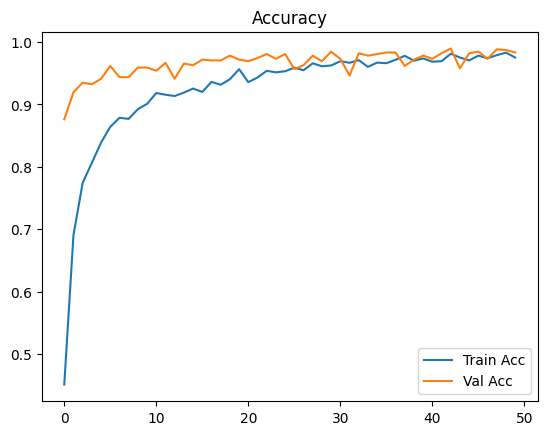

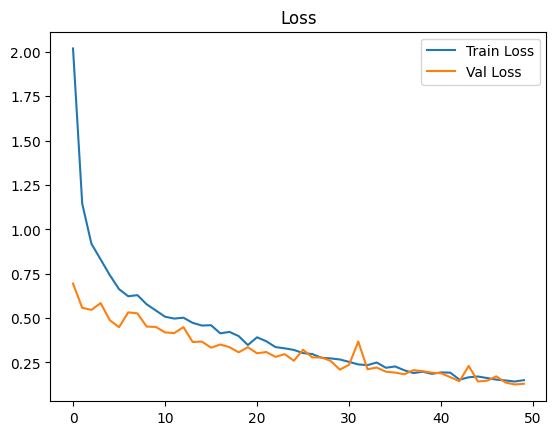

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step
                                          precision    recall  f1-score   support

                               Akhenaten       1.00      1.00      1.00        21
                Bent-pyramid-for-senefru       1.00      0.99      0.99        74
          Colossal-Statue-of-Ramesses-II       1.00      0.95      0.98        21
                      Colossoi-of-Memnon       1.00      0.94      0.97        52
             Goddess-Isis-with-her-child       1.00      1.00      1.00        17
                              Hatshepsut       0.96      0.99      0.97        69
                         Hatshepsut-face       1.00      1.00      1.00        18
                          Khafre-Pyramid       1.00      0.98      0.99       107
                     Mask-of-Tutankhamun       1.00      1.00      1.00        44
                               Nefertiti       1.00      1.00      1.00        24
                       Pyramid_of_Djoser       1.00   

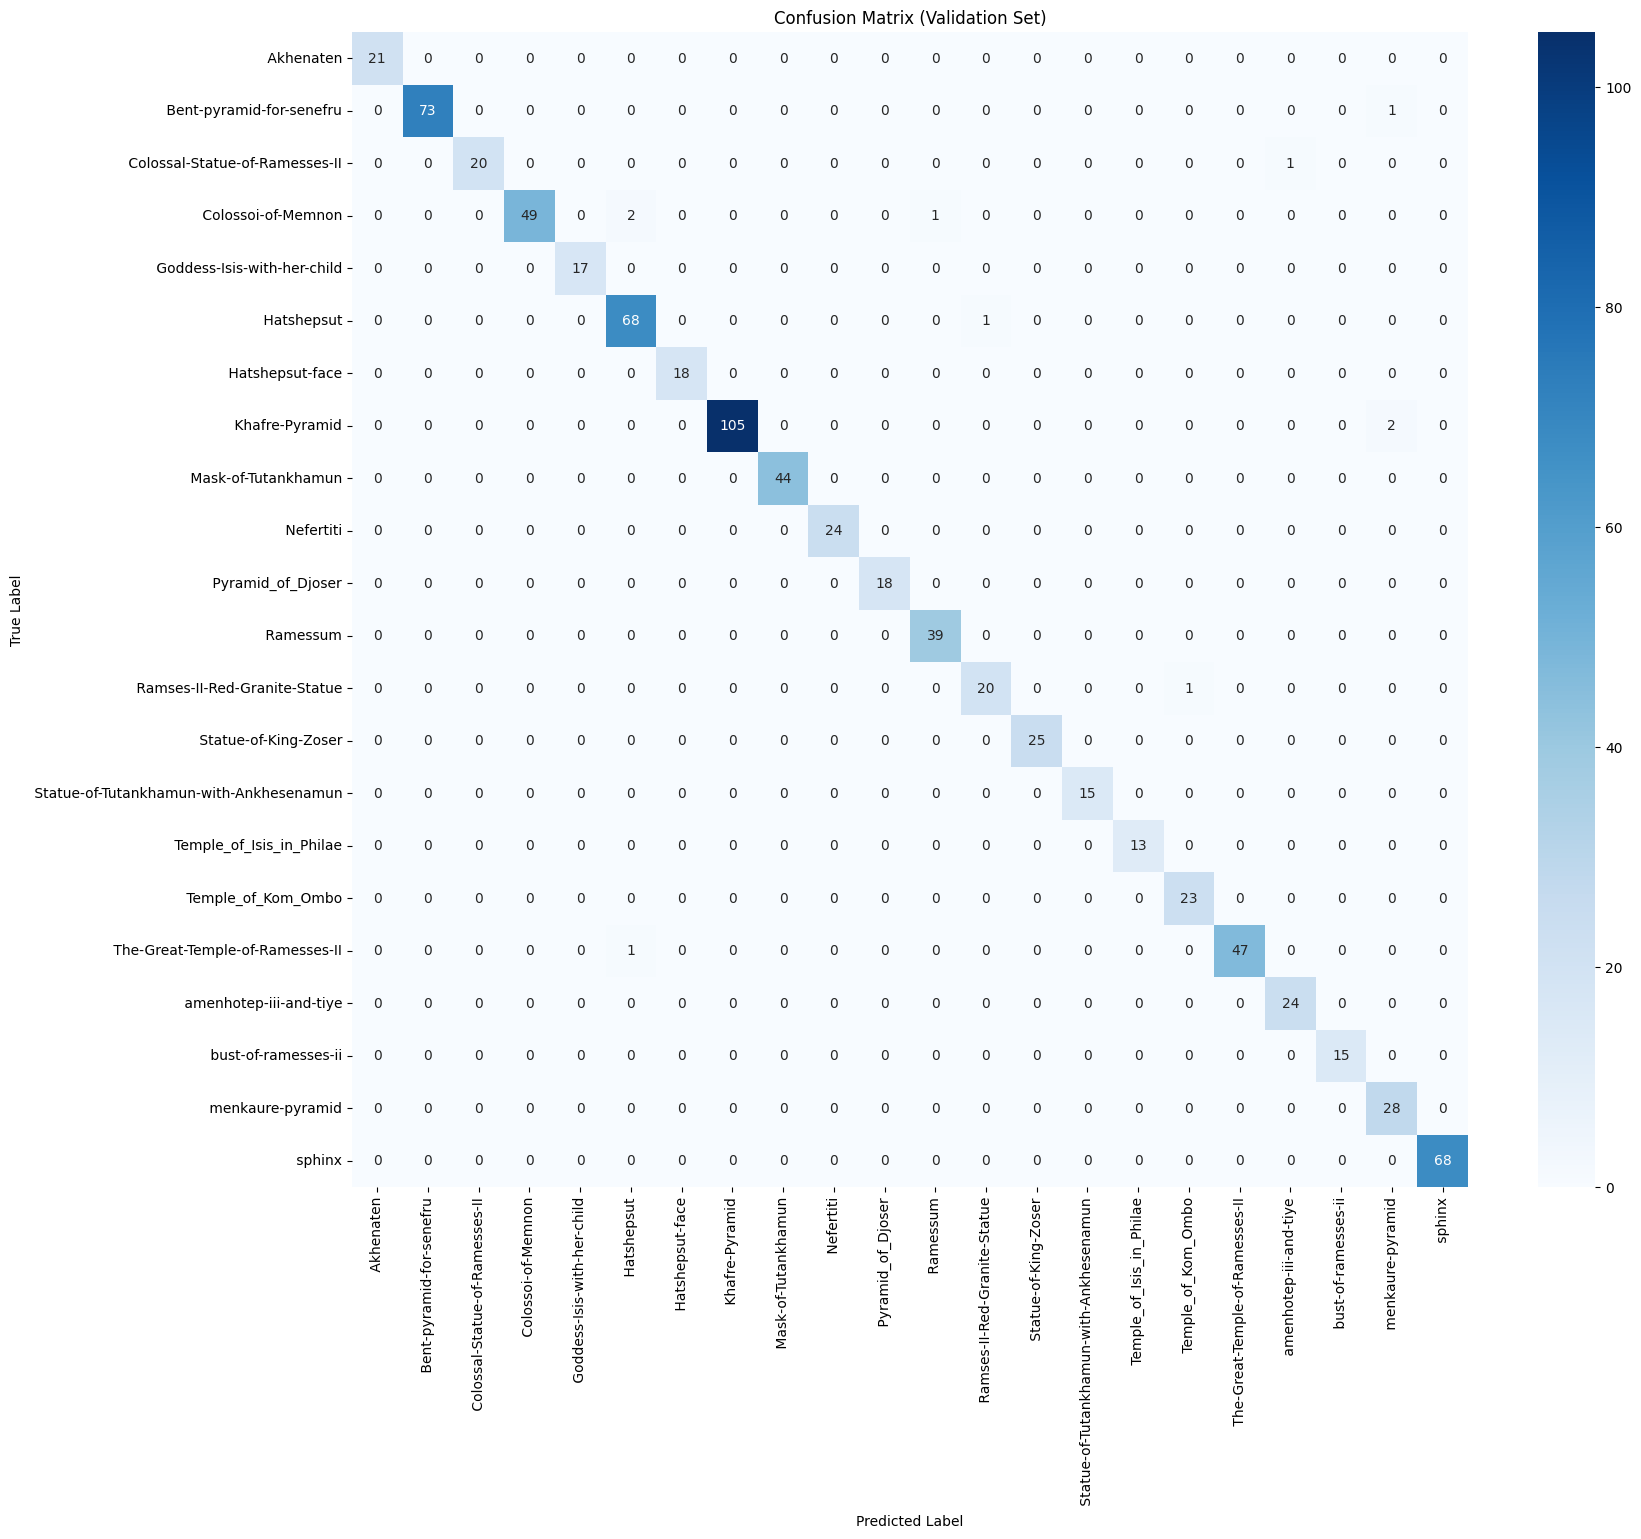

In [ ]:
Y_pred = model.predict(valid_gen)
Y_pred_classes = np.argmax(Y_pred, axis=1)

valid_gen.reset()
Y_true = valid_gen.classes
class_names = list(valid_gen.class_indices.keys())

print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

In [ ]:
from google.colab import files
files.download("best_resnet50.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>